# Head

## imports

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function , division
from __future__ import absolute_import
from __future__ import unicode_literals

In [2]:
%matplotlib inline
import logging
import datetime
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import itertools
import glob
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
from pylab import rcParams
import shutil

import keras
from keras.models import Sequential , Model
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, BatchNormalization, GaussianNoise , Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate, Input
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import ReLU , LeakyReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model , np_utils
from keras.models import model_from_json
from keras.optimizers import SGD , RMSprop ,Adam

import tensorflow as tf
from keras.backend import tensorflow_backend as K

from time import gmtime, strftime
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## memoryの制限

In [3]:
# memoryの制限
config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0"
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [4]:
#GPUを認識できてるか確認
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

## Tuning

In [5]:
#Tuning
# dataset = "ModelNet10"
# dataset = "ModelNet40"
dataset = "3D_SAMPLE"
n_points = 10000
cell = 32
batch_size = 128
epochs = 40
learning_rate = 0.001
dir_rename_flag = False

In [6]:
if dataset == "ModelNet10":
    data_dir = "ModelNet10/"
    num_classes = 10
    extension = ".off"
    class_name = [
    'bathtub',
    'chair',
    'dresser',
    'night_stand',
    'table',
    'bed',
    'desk',
    'monitor',
    'sofa',
    'toilet',
    ]

In [7]:
if dataset == "ModelNet40":
    data_dir = "ModelNet40/"
    num_classes = 40
    extension = ".off"
    class_name = [
    'airplane',
    'bookshelf',
    'chair',
    'desk',
    'glass_box',
    'laptop',
    'person',
    'range_hood',
    'stool',
    'tv_stand',
    'bathtub',
    'bottle',
    'cone',
    'door',
    'guitar',
    'mantel',
    'piano',
    'sink',
    'table',
    'vase',
    'bed',
    'bowl',
    'cup',
    'dresser',
    'keyboard',
    'monitor',
    'plant',
    'sofa',
    'tent',
    'wardrobe',
    'bench',
    'car',
    'curtain',
    'flower_pot',
    'lamp',
    'night_stand',
    'radio',
    'stairs',
    'toilet',
    'xbox',
    ]

In [8]:
if dataset == "3D_SAMPLE":
    data_dir = "3D_SAMPLE/"
    num_classes = 34
    extension = ".stl"
    class_name = [
    'auto_valve1',
    'auto_valve2',
    'auto_valve3',
    'bearing',
    'bevel_gear',
    'block',
    'bracket1',
    'bracket2',
    'bushing',
    'cylinder',
    'etc',
    'frame',
    'gear',
    'handle_valve1',
    'handle_valve2',
    'handle_valve3',
    'hinge1',
    'hinge2',
    'nut',
    'pipe',
    'plate',
    'pully1',
    'pully2',
    'robot1',
    'robot2',
    'robot3',
    'robot4',
    'rod',
    'shaft1',
    'shaft2',
    'spring',
    'trigeminal_valve',
    'valve_connector',
    'washer'
    ]

In [9]:
train_or_test = ["train","test"]

In [10]:
# optimizer = SGD(lr=learning_rate)
# optimizer = RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
optimizer = Adam(lr=learning_rate)

## Directory関連

In [11]:
#読み込み，書き込み用ディレクトリ
data_dir = data_dir
vox_dir = "np_vox/" + dataset + "/cell" + str(cell) + "/"
fig_dir =  "figure/"+ dataset + "/cell" + str(cell) + "/"
weights_dir = "weights/" + dataset + "/cell" + str(cell) + "/"
model_dir = "model/"+ dataset + "/cell" + str(cell) + "/"
dist_dir = "dist/"+ dataset + "/cell" + str(cell) + "/"

In [12]:
data_dir

'3D_SAMPLE/'

In [13]:
if os.path.exists(vox_dir) == False:
    os.makedirs(vox_dir)
if os.path.exists(weights_dir) == False:
    os.makedirs(weights_dir)
if os.path.exists(fig_dir) == False:
    os.makedirs(fig_dir)
if os.path.exists(model_dir) == False:
    os.makedirs(model_dir)
if os.path.exists(dist_dir) == False:
    os.makedirs(dist_dir)

In [14]:
# TrainとTestのデータdirectory作成
for t in train_or_test:
    for cl in class_name:
        if os.path.exists(data_dir + cl + "/" + t + "/") == False:
            os.makedirs(data_dir + cl + "/" + t + "/")

# 関数

## ファイル読み込み

In [15]:
def load_off(filename):
    # read OFF file
    with open(filename,"r") as handle:
        off = handle.read().rstrip().split("\n")
        
    #OFFファイルが不正かどうか判定
    if off[0] != "OFF":
#         print("{} is broken!!".format(filename))
        params = list(off[0].split(" "))
        n_vertices = int(params[0].strip("OFF"))
        n_faces = int(params[1])
        off.insert(0, "OFF")
    
    else:
        #get params and faces
        params = list(map(int, off[1].split(" ")))
        n_vertices = params[0]
        n_faces = params[1]

    # read  Vertex coordinates
    vertices = []
    for n in range(n_vertices):
        coords = list(map(float, off[2+n].split()))
        vertices.append(coords)

    # read information of faces
    faces = []
    for n in range(n_faces):
        connects = list(map(int, off[2 + n_vertices + n].split(" ")[1:4]))
        faces.append(connects)

    return vertices, faces

In [16]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

In [17]:
def get_index_2d_list(retrieval_object,array):
    return [i for i, x in enumerate(retrieval_object) if x == array][0]

In [18]:
def load_stl(filename):
    # read STL file
    with open(filename,"r") as handle:
        stl = handle.read().rstrip().split("\n")
        
    #get vertice
    vertice = []
    for i in range(len(stl)):
        pool = stl[i].split()
        if pool[0] == "vertex":
            vertex = list(map(float, pool[1:]))
            vertice.append(vertex)
            
    unique_vertice = get_unique_list(vertice)
            
    #get faces
    faces = []
    for n in range(len(stl)):
        if stl[n].split() == ['outer', 'loop']:
            indexes = []
            for i in range(3):
                index = get_index_2d_list(unique_vertice, list(map(float,stl[n+i+1].split()[1:])))
                indexes.append(index)
            faces.append(indexes)

    return unique_vertice, faces

## 点群発生系

In [19]:
def calc_vector_norm(a):
#     何も分からん
    norm = 0.0
    for el in a:
        norm += el *el
    return math.sqrt(norm)

In [20]:
def calc_cross_product_3d(a,b):
#     なんもわからん
    return [a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2],a[0]*b[1]-a[1]*b[0]]

In [21]:
def calc_triangle_area(a, b, c):
#     なんもわからん
    ca = [c[0]-a[0], c[1]-a[1], c[2]-a[2]]
    ba = [b[0]-a[0], b[1]-a[1], b[2]-a[2]]
    cross = calc_cross_product_3d(ca, ba)
    return 0.5 * calc_vector_norm(cross)

In [22]:
def calc_cumulative_areas(vertices, faces):
#     なんもわからん
    cuma = 0.0
    cum_areas = []
    for fc in faces:
        cuma += calc_triangle_area(
            vertices[fc[0]], vertices[fc[1]], vertices[fc[2]])
        cum_areas.append(cuma)
    return cum_areas

In [23]:
def random_select_face_id(cum_areas):
#     なんもわからん
    rand_area = cum_areas[-1] * random.random()
    select_id = 0
    for n in range(len(cum_areas)):
        if rand_area <= cum_areas[n]:
            select_id = n
            break
    return select_id

In [24]:
def gen_random_points(vertices, faces, n_points):
#     なんもわからん
    cum_areas = calc_cumulative_areas(vertices, faces)
    points = []
    for n in range(n_points):
        fid = random_select_face_id(cum_areas)
        r1 = math.sqrt(random.random())
        r2 = random.random()
        a = vertices[faces[fid][0]]
        b = vertices[faces[fid][1]]
        c = vertices[faces[fid][2]]
        xp = (1 - r1) * a[0] + r1 * (1 - r2) * b[0] + r1 * r2 * c[0]
        yp = (1 - r1) * a[1] + r1 * (1 - r2) * b[1] + r1 * r2 * c[1]
        zp = (1 - r1) * a[2] + r1 * (1 - r2) * b[2] + r1 * r2 * c[2]
        points.append([xp, yp, zp])
    return points

## 可視化ツール

In [25]:
def plot3D(np_pc):
    #3D表示
    fig = plt.figure(1,figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2],s = 2)
    ax.axis("equal")
    plt.show()

In [26]:
def plot_trihedral_figure_vox(np_pc):
    #Voxel版三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=10)
#         plt.xlim([-2,32]) 
#         plt.ylim([-2,32]) 
        plt.gca().set_aspect('equal')
        plt.show()

In [27]:
def plot_trihedral_figure(np_pc):
    #三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=2)
        plt.axis('equal')
        plt.show()

In [28]:
def plot_confusion_matrix(data, 
                          label,
                          classes=class_name,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    labels_pred = model.predict_classes(data,verbose=0)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), labels_pred)
    np.set_printoptions(precision=2)
    cm_normalize = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cnf_matrix.max() / 2
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    plt.savefig(fig_dir + 'Normalized_confusion_matrix.svg')
    plt.show()


## ボクセル系

In [29]:
def voxilize(np_pc,cell):
# ボクセル化した配列を返す
    max_dist = 0.0
    for it in range(0,3):
        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_

        #xyzで一番並行距離が大きいのを求める
        if dist > max_dist:
            max_dist = dist
            
    for it in range(0,3):

        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_
        
        #中心座標を 0,0,0にセットする（原点が中心にくるようにする）
        np_pc[:,it] = np_pc[:,it] - dist/2 - min_

        #covered cell
        cls = cell - 3

        #ボクセル一個当たりのサイズを求める
        vox_sz = max_dist/(cls-1)

        #上で算出した値で各点を割る。これで各点は(-14, 14)の範囲の値になる
        np_pc[:,it] = np_pc[:,it]/vox_sz

        #各点が全て正の整数になるよう移動。これで各点は[0, 30]になる（多分）
        np_pc[:,it] = np_pc[:,it] + (cls-1)/2


    #整数にする
    np_pc = np.rint(np_pc).astype(np.uint32)


    #３０＊３０＊３０の配列を作り，点が存在する場合は1、存在しない場合は0を入力する。
    vox = np.zeros([cell-2,cell-2,cell-2])

    # (pc_x, pc_y, pc_z)にnp_pcの座標を代入する
    for (pc_x, pc_y, pc_z) in np_pc:

#     # 点が存在しても20%の確率で0とし、データにノイズを加え、汎用性を上げている
#     # ここ，ノイジーなデータの場合８０よりも小さい数字にしたほうがいいかもね？
#         if random.randint(0,100) < 80:
        vox[pc_x, pc_y, pc_z] = 1

    np_vox = np.zeros([1,cell,cell,cell,1])
    np_vox[0, 1:-1, 1:-1, 1:-1,0] = vox

    return np_vox

In [30]:
def voxel_scatter(np_vox):
# キレイに整形するやつ
    #空の配列を作る
    vox_scat = np.zeros([0,3], dtype= np.uint32)

    #32回
    for x in range(0,np_vox.shape[1]):
        #32回
        for y in range(0,np_vox.shape[2]):
            #32回
            for z in range(0,np_vox.shape[3]):
                #（ｘ，ｙ，ｚ）に１が入っていればその座標を返す
                if np_vox[0,x,y,z,0] == 1.0:
                    arr_tmp = np.zeros([1,3],dtype=np.uint32)
                    arr_tmp[0,:] = (x,y,z)
                    vox_scat = np.concatenate((vox_scat,arr_tmp))
    return vox_scat

## ボクセルの読み込み

In [31]:
def load_vox(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_stl(filename)
    points = gen_random_points(vertices, faces, n_points)
    # ValueError: sequence too large; cannot be greater than 32の回避策
    # list 2 numpy.ndarray
    pc = np.empty((len(points), len(points[0])))
    pc[:] = points
    vox = voxilize(pc,cell)

    return vox

## tensorboard

In [32]:
def make_tensorboard(set_dir_name='TensorBoard'):
    log_dir = set_dir_name
    if os.path.exists(log_dir) == False:
        os.makedirs(log_dir)
    tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, )
    return tensorboard

## 距離の計算

In [33]:
# XYZ 長さの取得
def calc_dist(filename):
    vertices, faces = load_stl(filename)
    point =  np.array(vertices)
    dist = np.zeros(3)
    for i in range(0,3):
        min_ = np.amin(point[:,i])
        max_ = np.amax(point[:,i])
        dist_ = max_ - min_
        if dist_ < 0.001:
            dist_ = 0.001
        dist[i] = dist_
    return dist

In [34]:
def index_to_class(index):
    return class_name[label[index].argmax()]

# ボクセル化

## データセットのリネーム処理

In [61]:
if dir_rename_flag == False:
    if dataset == "3D_SAMPLE":
        # train_or_testの分ける
        for cl in class_name:
            namelist = glob.glob(data_dir+ cl +"/*")
            namelist.remove(data_dir+ cl + "/train")
            namelist.remove(data_dir+ cl + "/test")
            for i in range(len(namelist)):
                if i%5 == 0 :
                    shutil.move(namelist[i], data_dir + cl + "/test/.")
        #             print(namelist[i])
                else:
                    shutil.move(namelist[i], data_dir + cl + "/train/.")
        #             print(namelist[i])
    #  ====================rename===============================
    for cl in class_name:
        print('Renameing {} files ...'.format(cl))
        for t in train_or_test:
            i = 0
            #ファイル名を取得
            namelist = glob.glob(data_dir+ cl +"/" + t + "/*")
            if data_dir+ cl +"/" + t + "/0" + extension in namelist:
                print(t +" is already renamed!!")
                continue
            for file in namelist:
                os.rename(file, data_dir+ cl +'/' + t +"/"+ str(i) + extension)
                i+=1
    print("Rename all!")
    dir_rename_flag = True
    #  ====================rename===============================

## demo

In [62]:
# demo
vertices, faces = load_stl("3D_SAMPLE/spring/test/0.stl")
points = gen_random_points(vertices, faces, n_points)

In [63]:
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points
print(type(test))


<class 'numpy.ndarray'>


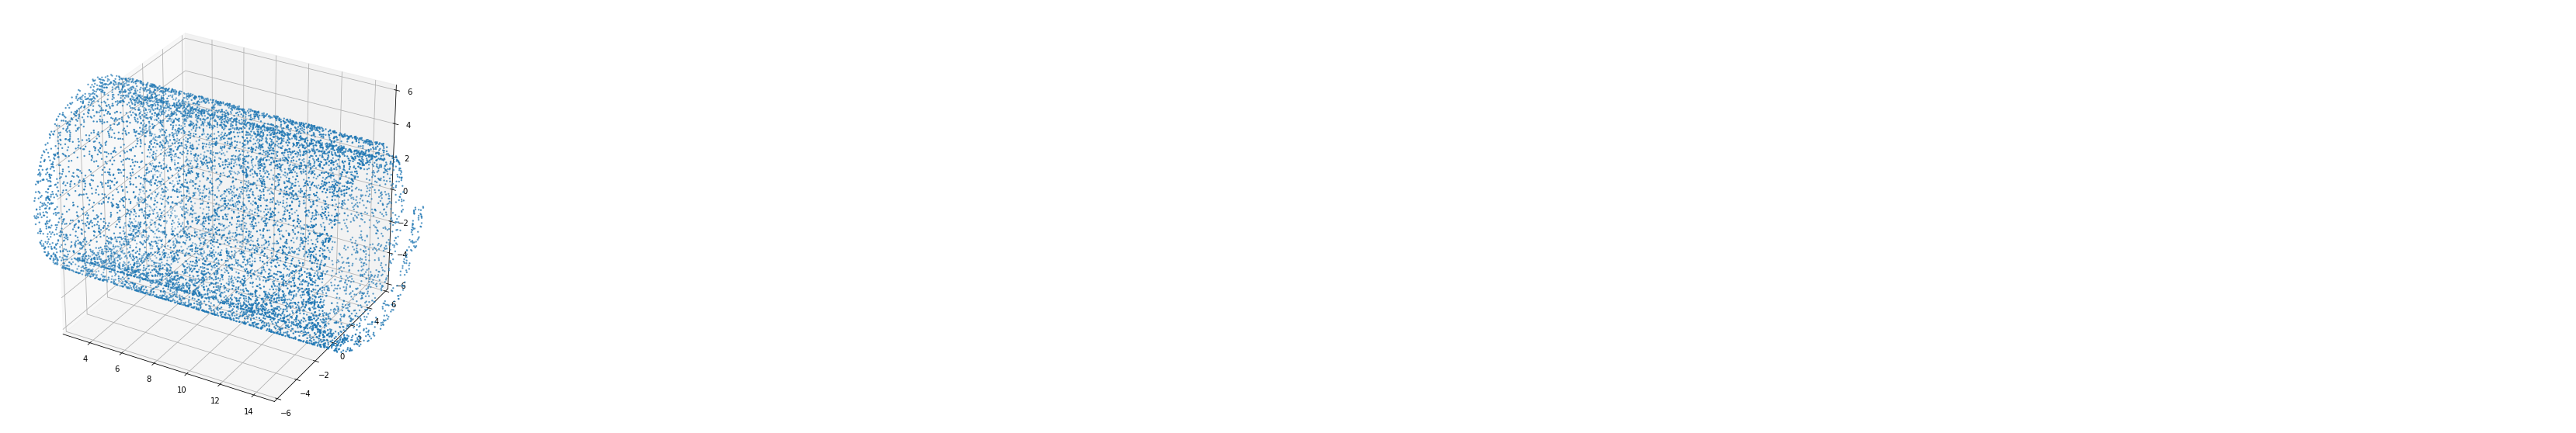

In [64]:
plot3D(test)

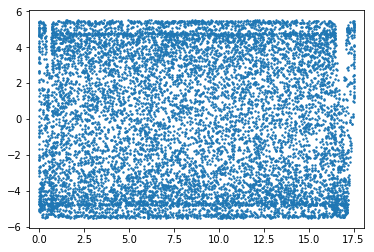

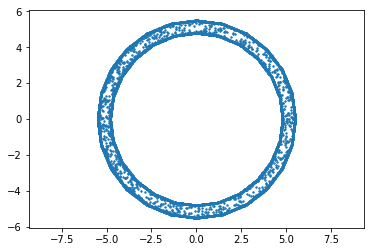

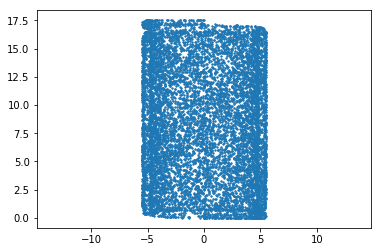

In [65]:
plot_trihedral_figure(test)

In [66]:
#voxelize
test_vox = voxilize(test,cell)

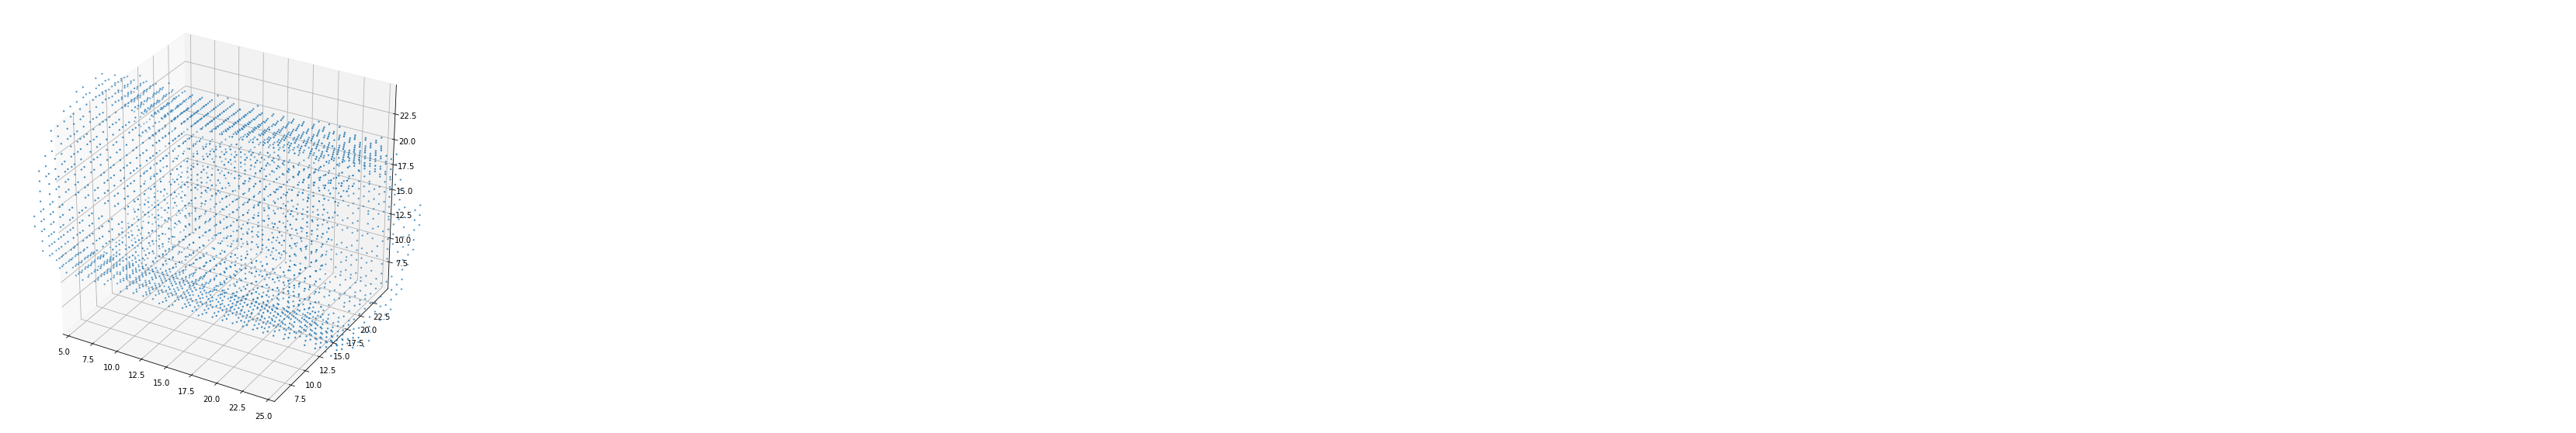

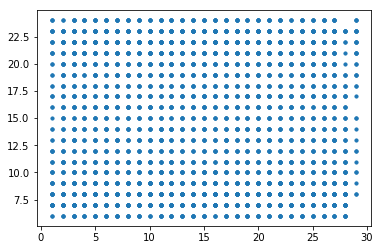

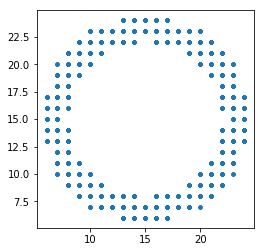

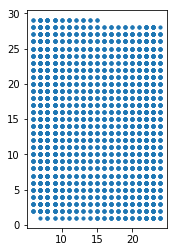

shape is (1, 32, 32, 32, 1)


In [67]:
#turn
vox_scat = voxel_scatter(test_vox)
plot3D(vox_scat)
plot_trihedral_figure_vox(vox_scat)
print("shape is {}".format(test_vox.shape))

##  ボクセルのnumpy保存

In [42]:
off_voxilize = False

for t in train_or_test:
    for cl in  tqdm(class_name):
        print(cl)
        
        #すでにボクセル化が済んていればスキップ
        if os.path.exists(vox_dir + "x_train.npy") == True:
#             print("{} is exist.".format(vox_dir + cl + t + ".npy"))
            off_voxilize = True
            continue
        
        #すでに存在してるnpyファイルはスキップ
        if os.path.exists(vox_dir + cl + t + ".npy") == True:
            print("{} is exist.".format(data_dir + cl + t + ".npy"))
            continue
        
        num = glob.glob(data_dir+ cl +"/" + t + "/*")
        for i in tqdm(range(len(num))):
#             print(data_dir + cl + "/" + t +"/"+ str(i) + ".stl")
            if i ==0  :
                off = load_vox(data_dir + cl + "/" + t +"/"+ str(i) + extension)
                continue
            off_ =  load_vox(data_dir + cl + "/" + t +"/"+ str(i) + extension)
            
            off = np.append(off, off_, axis=0)
        np.save(vox_dir + cl + t + ".npy", off)
#クラス毎，TestTrain毎ボクセル化されたnpzが生成される（N,32,32,32,1）

auto_valve1
auto_valve2
auto_valve3
bearing
bevel_gear
block
bracket1
bracket2
bushing
cylinder
etc
frame
gear
handle_valve1
handle_valve2
handle_valve3
hinge1
hinge2
nut
pipe
plate
pully1
pully2
robot1
robot2
robot3
robot4
rod
shaft1
shaft2
spring
trigeminal_valve
valve_connector
washer



auto_valve1
auto_valve2
auto_valve3
bearing
bevel_gear
block
bracket1
bracket2
bushing
cylinder
etc
frame
gear
handle_valve1
handle_valve2
handle_valve3
hinge1
hinge2
nut
pipe
plate
pully1
pully2
robot1
robot2
robot3
robot4
rod
shaft1
shaft2
spring
trigeminal_valve
valve_connector
washer



In [43]:

#ココらへん可読性わるすぎ
if not off_voxilize:
    # データ整形
    for t in train_or_test:
        swich_npy = True 
        num_of_data = []#init
        for cl in class_name:
            if swich_npy == True:
                npy = np.load(vox_dir  + cl + t + ".npy")
                num_of_data.append(npy.shape[0])
                swich_npy = False
            else:
                npy_ = np.load(vox_dir  + cl + t + ".npy")
                npy = np.append(npy,npy_,axis=0)
                num_of_data.append(npy_.shape[0])
        if t == "train":
            x_train = npy
            y_train = num_of_data
        if t == "test":
            x_test = npy
            y_test = num_of_data
            
        
    # ラベルの生成
    for t in train_or_test:
        if t == "train":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_train[i] , i )    
                else:
                    label_ = np.full(y_train[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_train = label

        if t == "test":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_test[i] , i )    
                else:
                    label_ = np.full(y_test[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_test = label


# convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    # 保存
    npy = ["x_train.npy" , "x_test.npy" , "y_train.npy" , "y_test.npy"]
    data = [x_train , x_test , y_train , y_test]
    for i in range(len(npy)):
        np.save(vox_dir + npy[i],data[i])
        
    # 不要ファイルの除去
    for i in os.listdir(vox_dir):
        if not i in npy:
            os.remove(vox_dir + i)

# modelの定義

## init model

In [44]:
# init model
model = Sequential()

# convolution 1
model.add(Conv3D(input_shape=(cell, cell, cell,1),
                            nb_filter=32,
                            kernel_dim1=5,
                            kernel_dim2=5,
                            kernel_dim3=5,
                            init='normal',
                            border_mode='valid',
                            subsample=(2, 2, 2),
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 1
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))



#Activation ReLu
model.add(ReLU())

# dropout 1
model.add(Dropout(p=0.4))

# convolution 2
model.add(Conv3D(nb_filter=32,
                            kernel_dim1=3,
                            kernel_dim2=3,
                            kernel_dim3=3,
                            init='normal',
                            border_mode='valid',
                            subsample=(1, 1, 1),
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 2
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))

#Activation ReLu
model.add(ReLU())

# max pool 1
model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=None,
                           border_mode='valid'))

# dropout 2
model.add(Dropout(p=0.4))

# dense 1 (fully connected layer)
model.add(Flatten())

model.add(Dense(output_dim=528, #128
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

# dropout 3
model.add(Dropout(p=0.5))

# dense 2 (fully connected layer)
model.add(Dense(output_dim=num_classes,
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

#Activation Softmax
model.add(Activation("softmax"))


/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(input_shape=(32, 32, 3..., kernel_size=(5, 5, 5), filters=32, strides=(2, 2, 2), padding="valid", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
  
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(kernel_size=(3, 3, 3), filters=32, strides=(1, 1, 1), padding="valid", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), stride

## モデルの保存

In [45]:
#モデルの保存
json_string = model.to_json()
open(model_dir+'voxnet_model.json', 'w').write(json_string)

3810

## modelの読み込み

In [46]:
#モデルの読み込み
model_data = open("model/" + dataset + "/cell" + str(cell) + "/voxnet_model.json").read()
model = model_from_json(model_data)

In [47]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

## モデル可視化

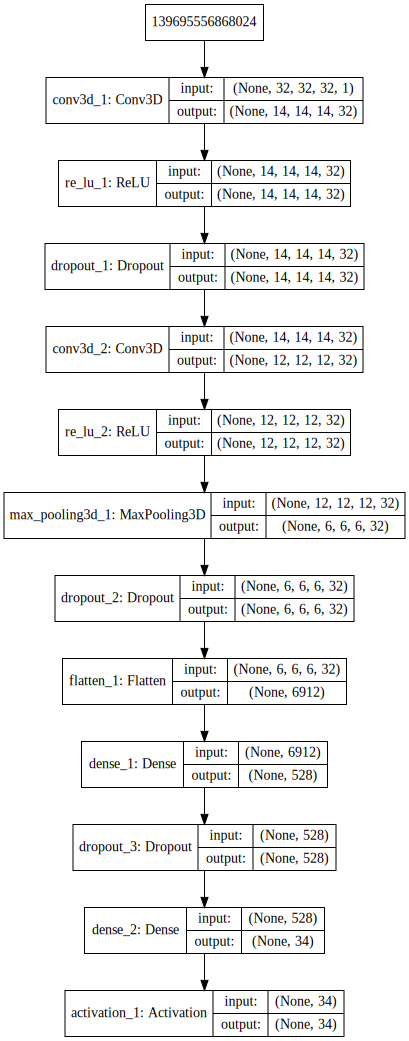

In [48]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [49]:
#モデルの図を保存
plot_model(model, to_file=fig_dir + 'model.png',show_shapes='True')

## summary

In [50]:
#サマリーの表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 14, 14, 14, 32)    4032      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 14, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 12, 12, 12, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 32)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 6, 32)       0         
__________

In [51]:
model

# Train

## ボクセルのLoad

In [52]:
x_train = np.load( vox_dir  + "x_train.npy")
x_test = np.load( vox_dir  + "x_test.npy")
y_train = np.load( vox_dir + "y_train.npy")
y_test = np.load( vox_dir + "y_test.npy")

In [53]:
x_train.shape

(3114, 32, 32, 32, 1)

In [54]:
y_train.shape

(3114, 34)

In [55]:
x_test.shape

(795, 32, 32, 32, 1)

In [56]:
y_test.shape

(795, 34)

## callback

In [57]:
# early_stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

In [58]:
#save best model
checkpoint = ModelCheckpoint(filepath = os.path.join(weights_dir, "model-{epoch:02d}.h5"), save_best_only=True)

In [59]:
# TensorBoard
callbacks = [make_tensorboard(),checkpoint]

## fit

In [60]:
result = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test) ,
                   callbacks=callbacks)

time_now = datetime.datetime.now()
time_now = "_{0}_{1}_{2}_{3}_{4}_{5}".format(time_now.year, time_now.month, time_now.day,
                                             time_now.hour, time_now.minute, time_now.second)
model.save_weights(weights_dir+"weights_{0}.h5".format(time_now), False)

Train on 3114 samples, validate on 795 samples
Epoch 1/40
3114/3114 [==============================] - 4s 1ms/step - loss: 12.4216 - acc: 0.3176 - val_loss: 10.8222 - val_acc: 0.5019
Epoch 2/40
3114/3114 [==============================] - 3s 855us/step - loss: 9.8364 - acc: 0.6150 - val_loss: 9.0034 - val_acc: 0.7887
Epoch 3/40
3114/3114 [==============================] - 3s 841us/step - loss: 8.3060 - acc: 0.7961 - val_loss: 7.7595 - val_acc: 0.8704
Epoch 4/40
3114/3114 [==============================] - 3s 869us/step - loss: 7.1781 - acc: 0.8764 - val_loss: 6.7021 - val_acc: 0.9119
Epoch 5/40
3114/3114 [==============================] - 3s 836us/step - loss: 6.2511 - acc: 0.9159 - val_loss: 5.8763 - val_acc: 0.9409
Epoch 6/40
3114/3114 [==============================] - 3s 850us/step - loss: 5.4728 - acc: 0.9355 - val_loss: 5.1621 - val_acc: 0.9484
Epoch 7/40
3114/3114 [==============================] - 3s 855us/step - loss: 4.8069 - acc: 0.9483 - val_loss: 4.5629 - val_acc: 0.9472
E

KeyboardInterrupt: 

In [ ]:
# # 重みの読み込み
# model.load_weights("weights/ModelNet10/cell32/weights__2018_11_29_15_46_12.h5")
# model.load_weights("weights/ModelNet40/cell32/weights__2018_12_29_16_15_51.h5")


# evaluate

In [ ]:
loss,acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

In [ ]:
# 重みを読み込んで評価
# model.load_weights("weights/"+dataset+"/cell32/model-38.h5")
# loss,acc = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', loss)
# print('Test accuracy:', acc)

## learning validation curve 

In [ ]:
rcParams["figure.figsize"] = [6.4, 4.8]

In [ ]:
# plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
# plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.ylim([0.5,1])
# plt.legend()
# plt.title(" {} / cell {}".format(dataset,cell))
# plt.savefig(fig_dir + 'acc.svg')
# plt.show()

In [ ]:
# plt.plot(range(1, len(result.history['loss'])+1), result.history['loss'], label="loss")
# plt.plot(range(1, len(result.history['val_loss'])+1), result.history['val_loss'], label="validation_loss")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title(" {} / cell {}".format(dataset,cell))
# plt.savefig(fig_dir  + 'loss.svg')
# plt.show()

## Confusion matrix

In [ ]:
labels_pred = model.predict_classes(x_test,verbose=0)

In [ ]:
labels_pred.shape

In [ ]:
labels_pred

In [ ]:
np.argmax(y_test, axis=1)

In [ ]:
# 間違ったやつのIndex
np.where((labels_pred == np.argmax(y_test, axis=1)) == 0)

In [ ]:
# グラフのサイズ
rcParams['figure.figsize'] = 10,8


# Plot normalized confusion matrix
plot_confusion_matrix(x_test,y_test)


## 個別に分類

In [ ]:
vertices, faces = load_off(dataset+"/chair/train/0.off")
points = gen_random_points(vertices, faces, n_points)
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points
print(type(test))
#voxelize
test_vox = voxilize(test,cell)

In [ ]:
# model.load_weights('weights/'+dataset+'/cell32/model-40.h5')

# 読み込んだ学習済みモデルで予測
proba_all = model.predict(test_vox)
print(proba_all)
proba = np.argmax(proba_all)
print(proba_all[0][proba])
print(class_name[proba])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(class_name , proba_all[0])
ax.set_xticklabels(class_name, rotation=90)
plt.show()

# 距離の計算

In [ ]:
dist_calcrated = False
for t in train_or_test:
    for cl in  tqdm(class_name):
        print(cl)
        
        #すでに距離の計算が済んていればスキップ
        if os.path.exists(dist_dir + "x_train.npy") == True:
#             print("{} is exist.".format(vox_dir + cl + t + ".npy"))
            dist_calcrated = True
            continue
        
        #すでに存在してるnpyファイルはスキップ
        if os.path.exists(dist_dir + cl + t + ".npy") == True:
#             print("{} is exist.".format(data_dir + cl + t + ".npy"))
            continue
        
        num = glob.glob(data_dir+ cl +"/" + t + "/*")
        for i in tqdm(range(len(num))):
            if i ==0  :
                dist = calc_dist(data_dir + cl + "/" + t +"/"+ str(i) + extension)
                dist = [dist]
                continue
            dist_ =  calc_dist(data_dir + cl + "/" + t +"/"+ str(i) + extension                                                                                                              )
            
            dist = np.append(dist, [dist_], axis=0)
#             print(dist.shape)
        np.save(dist_dir + cl + t + ".npy", dist)

In [ ]:
#ココらへん可読性わるすぎ
if not dist_calcrated:
    # データ整形
    for t in train_or_test:
        swich_npy = True 
        num_of_data = []#init
        for cl in class_name:
            if swich_npy == True:
                npy = np.load(dist_dir  + cl + t + ".npy")
                num_of_data.append(npy.shape[0])
                swich_npy = False
            else:
                npy_ = np.load(dist_dir  + cl + t + ".npy")
                npy = np.append(npy,npy_,axis=0)
                num_of_data.append(npy_.shape[0])
        if t == "train":
            x_train = npy
            y_train = num_of_data
        if t == "test":
            x_test = npy
            y_test = num_of_data
            
        
    # ラベルの生成
    for t in train_or_test:
        if t == "train":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_train[i] , i )    
                else:
                    label_ = np.full(y_train[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_train = label

        if t == "test":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_test[i] , i )    
                else:
                    label_ = np.full(y_test[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_test = label


# convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    # 保存
    npy = ["x_train.npy" , "x_test.npy" , "y_train.npy" , "y_test.npy"]
    data = [x_train , x_test , y_train , y_test]
    for i in range(len(npy)):
        np.save(dist_dir + npy[i],data[i])
        
    # 不要ファイルの除去
#     for i in os.listdir(dist_dir):
#         if not i in npy:
#             os.remove(dist_dir + i)

## アスペクト比の可視化

/home/takitani/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


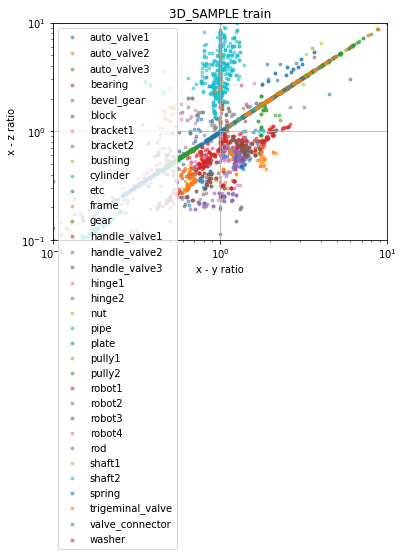

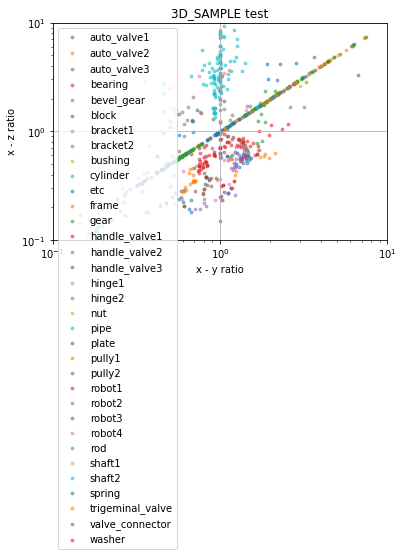

In [68]:
for t in train_or_test:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for cl in class_name:
        directory = dist_dir + cl + t + ".npy"
        xyz = np.load(directory)
        x = xyz[:,0]
        y = xyz[:,1]
        z = xyz[:,2]
        xy_ratio = y / x
        xz_ratio = z / x
        ax.scatter(xy_ratio , xz_ratio, label=cl, s= 8, alpha=0.5)
        

    ax.set_title(dataset + " " + t)
    ax.set_xlabel('x - y ratio')
    ax.set_ylabel('x - z ratio')
#     plt.xlim([0.025,40])
#     plt.ylim([0.025,40])
    plt.xlim([0.1,10])
    plt.ylim([0.1,10])
    plt.xscale("log")
    plt.yscale("log")
    

    ax.grid(True)

    ax.legend(loc='upper left')
    fig.savefig(fig_dir + t + "_asp.jpg")
    fig.show()

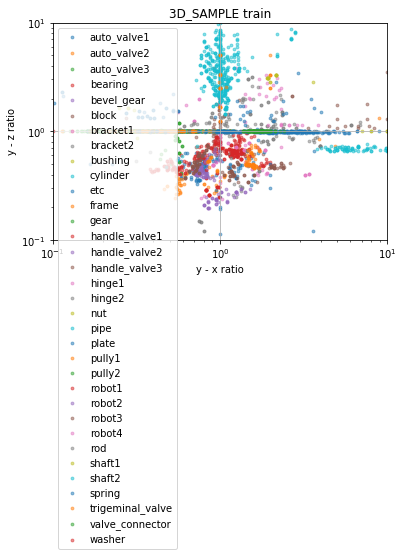

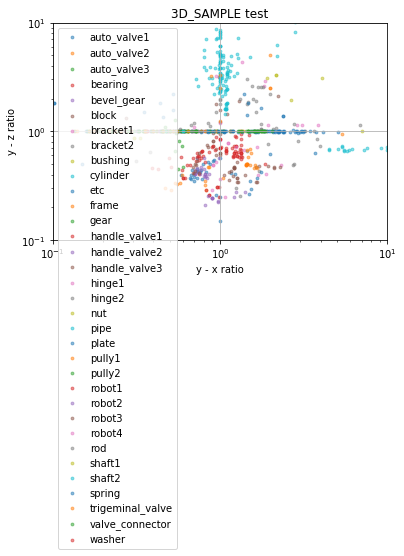

In [69]:
for t in train_or_test:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for cl in class_name:
        directory = dist_dir + cl + t + ".npy"
        xyz = np.load(directory)
        x = xyz[:,0]
        y = xyz[:,1]
        z = xyz[:,2]
        yx_ratio = x / y
        yz_ratio = z / y
        ax.scatter(yx_ratio , yz_ratio, label=cl, s= 8, alpha=0.5)
        

    ax.set_title(dataset + " " + t)
    ax.set_xlabel('y - x ratio')
    ax.set_ylabel('y - z ratio')
#     plt.xlim([0.025,40])
#     plt.ylim([0.025,40])
    plt.xlim([0.1,10])
    plt.ylim([0.1,10])
    plt.xscale("log")
    plt.yscale("log")
    

    ax.grid(True)

    ax.legend(loc='upper left')
    fig.show()

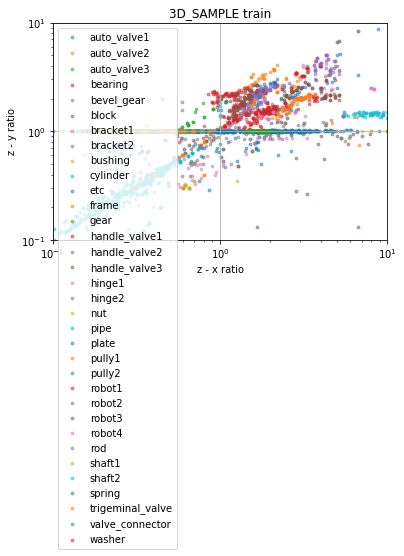

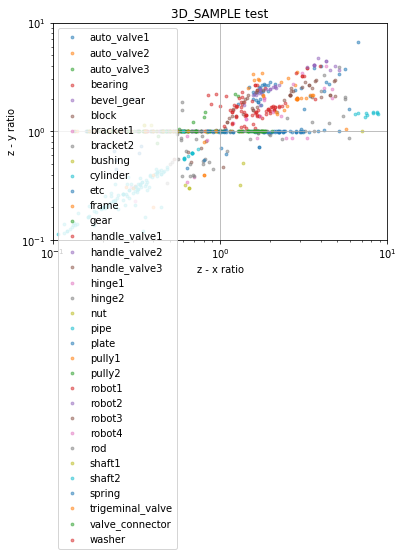

In [70]:
for t in train_or_test:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for cl in class_name:
        directory = dist_dir + cl + t + ".npy"
        xyz = np.load(directory)
        x = xyz[:,0]
        y = xyz[:,1]
        z = xyz[:,2]
        zx_ratio = x / z
        zy_ratio = y / z
        ax.scatter(zx_ratio , zy_ratio, label=cl, s= 8, alpha=0.5)
        

    ax.set_title(dataset + " " + t)
    ax.set_xlabel('z - x ratio')
    ax.set_ylabel('z - y ratio')
#     plt.xlim([0.025,40])
#     plt.ylim([0.025,40])
    plt.xlim([0.1,10])
    plt.ylim([0.1,10])
    plt.xscale("log")
    plt.yscale("log")
    

    ax.grid(True)

    ax.legend(loc='upper left')
    fig.show()

# アスペクト比の計算

In [71]:
directory = dist_dir +"x_train.npy"

xyz = np.load(directory)
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
xy_ratio = y / x
xz_ratio = z / x
aspect_train =  np.stack([xy_ratio,xz_ratio],axis=1)

In [72]:
directory = dist_dir +"x_test.npy"

xyz = np.load(directory)
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
xy_ratio = y / x
xz_ratio = z / x
aspect_test =  np.stack([xy_ratio,xz_ratio],axis=1)

ラベル(index)を入力したらそのモデルのパスを返す関数

In [76]:
index = 3857
t_or_t = "train"
for i  in range(num_classes):
    cl = class_name[i]
    npy = np.load(dist_dir  + cl + t_or_t + ".npy")
    print(cl)
    print("index : ", index)
    index = index - len(npy) 
    print("npy : ", len(npy))
    print("=====================")
    if index < 0 :
        print(i)
        break

auto_valve1
index :  3857
npy :  92
auto_valve2
index :  3765
npy :  38
auto_valve3
index :  3727
npy :  32
bearing
index :  3695
npy :  60
bevel_gear
index :  3635
npy :  217
block
index :  3418
npy :  78
bracket1
index :  3340
npy :  51
bracket2
index :  3289
npy :  164
bushing
index :  3125
npy :  11
cylinder
index :  3114
npy :  445
etc
index :  2669
npy :  43
frame
index :  2626
npy :  31
gear
index :  2595
npy :  296
handle_valve1
index :  2299
npy :  282
handle_valve2
index :  2017
npy :  70
handle_valve3
index :  1947
npy :  81
hinge1
index :  1866
npy :  41
hinge2
index :  1825
npy :  11
nut
index :  1814
npy :  30
pipe
index :  1784
npy :  24
plate
index :  1760
npy :  70
pully1
index :  1690
npy :  109
pully2
index :  1581
npy :  7
robot1
index :  1574
npy :  26
robot2
index :  1548
npy :  43
robot3
index :  1505
npy :  44
robot4
index :  1461
npy :  3
rod
index :  1458
npy :  46
shaft1
index :  1412
npy :  44
shaft2
index :  1368
npy :  83
spring
index :  1285
npy :  271
tr

# model構築２

In [77]:
#inputの定義
conv_input = Input(shape=(32, 32, 32 ,1), dtype="float32", name="conv_input")
aspect_input = Input(shape=(2,), dtype="float32", name="aspect_input")

# Conv3D部
conv_output = Conv3D(32,5,padding='valid',strides=(2, 2, 2),activation="relu")(conv_input)

conv_output = Dropout(0.4)(conv_output)

conv_output = Conv3D(32,3,padding='valid',strides=(1, 1, 1),activation="relu")(conv_output)

# conv_output = BatchNormalization()(conv_output)

conv_output = MaxPooling3D(pool_size=(2, 2, 2),strides=None, padding='valid')(conv_output)

conv_output = Dropout(0.4)(conv_output)

conv_output = Flatten()(conv_output)

# output = Flatten()(conv_output)

# output = BatchNormalization()(conv_output)

# アスペクト比部
aspect_output = Dense(128)(aspect_input)

aspect_output = Dropout(0.4)(aspect_output)

output = concatenate([conv_output, aspect_output])


# output = Dense(1024, #128
#                     kernel_initializer="normal",
#                     activation='linear',
#                     )(output)

output = Dropout(0.5)(output)

output = Dense(528, #128
                    kernel_initializer="normal",
                    activation='linear',
                    )(output)

output = Dropout(0.5)(output)

output = Dense(num_classes, activation="softmax")(output)

In [78]:
conv_output

<tf.Tensor 'flatten_2/Reshape:0' shape=(?, ?) dtype=float32>

In [79]:
model = Model(inputs=[conv_input, aspect_input], outputs=output)

In [80]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
conv3d_3 (Conv3D)               (None, 14, 14, 14, 3 4032        conv_input[0][0]                 
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 14, 14, 14, 3 0           conv3d_3[0][0]                   
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 12, 12, 12, 3 27680       dropout_4[0][0]                  
__________________________________________________________________________________________________
max_poolin

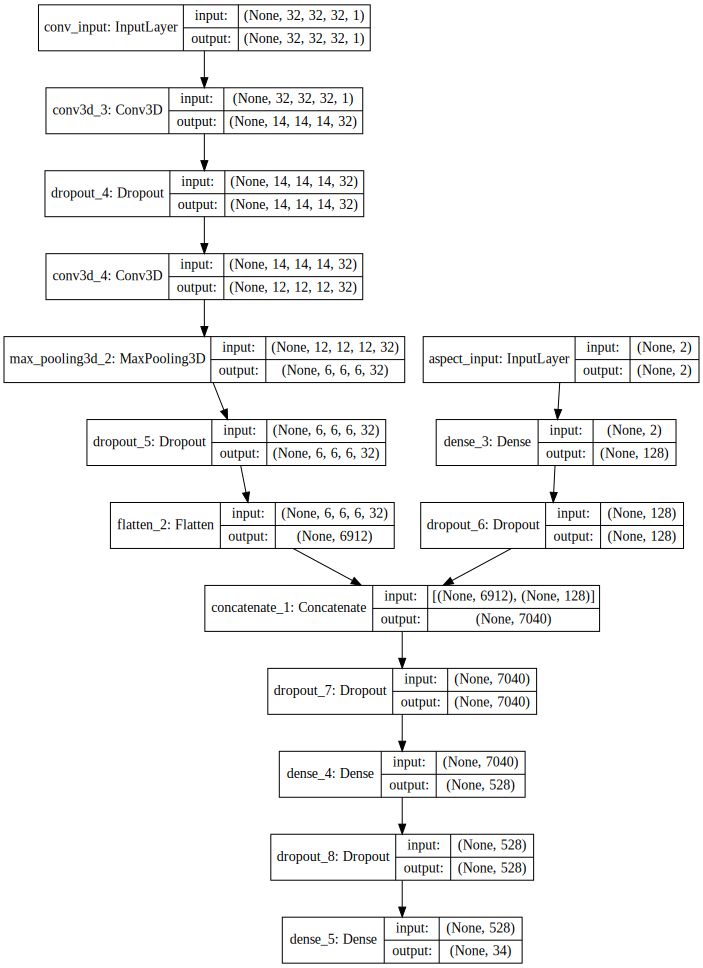

In [81]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
# #モデルの図を保存
# plot_model(model, to_file=fig_dir + 'model2.png',show_shapes='True')

In [82]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=["accuracy"])

# model.compile(loss='categorical_hinge', optimizer=optimizer, metrics=["accuracy"])


In [83]:
x_train = np.load( vox_dir  + "x_train.npy")
x_test = np.load( vox_dir  + "x_test.npy")
y_train = np.load( vox_dir + "y_train.npy")
y_test = np.load( vox_dir + "y_test.npy")

In [84]:
x_train.shape

(3114, 32, 32, 32, 1)

In [85]:
x_test.shape

(795, 32, 32, 32, 1)

In [86]:
y_train.shape

(3114, 34)

In [87]:
y_test.shape

(795, 34)

In [88]:
result = model.fit([x_train,aspect_train], y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=([x_test,aspect_test], y_test) ,
                   callbacks=callbacks)

Train on 3114 samples, validate on 795 samples
Epoch 1/40
3114/3114 [==============================] - 3s 815us/step - loss: 2.5868 - acc: 0.3311 - val_loss: 1.5235 - val_acc: 0.6176
Epoch 2/40
3114/3114 [==============================] - 2s 743us/step - loss: 1.2317 - acc: 0.6680 - val_loss: 0.9654 - val_acc: 0.7761
Epoch 3/40
3114/3114 [==============================] - 2s 735us/step - loss: 0.7567 - acc: 0.7932 - val_loss: 0.5652 - val_acc: 0.8893
Epoch 4/40
3114/3114 [==============================] - 2s 767us/step - loss: 0.5279 - acc: 0.8491 - val_loss: 0.4292 - val_acc: 0.9082
Epoch 5/40
3114/3114 [==============================] - 2s 786us/step - loss: 0.4241 - acc: 0.8767 - val_loss: 0.3710 - val_acc: 0.9132
Epoch 6/40
3114/3114 [==============================] - 2s 738us/step - loss: 0.3625 - acc: 0.8963 - val_loss: 0.2834 - val_acc: 0.9358
Epoch 7/40
3114/3114 [==============================] - 2s 765us/step - loss: 0.3027 - acc: 0.9146 - val_loss: 0.2706 - val_acc: 0.9358
E

In [90]:
model.predict([x_test,aspect_test])

array([[9.9999893e-01, 7.7095632e-07, 2.5052402e-09, ..., 2.8847900e-09,
        5.2749587e-14, 4.7120185e-15],
       [9.9999571e-01, 1.7733389e-11, 5.4449001e-10, ..., 5.2862589e-08,
        8.4052966e-11, 6.3505367e-14],
       [9.8664296e-01, 9.9209763e-10, 5.1085325e-12, ..., 1.7188653e-10,
        1.5366479e-11, 1.9109078e-16],
       ...,
       [2.4635119e-11, 2.9032495e-13, 6.8379025e-11, ..., 4.8494255e-12,
        4.8025806e-09, 9.9999750e-01],
       [1.4036741e-08, 5.5497620e-09, 7.5133727e-08, ..., 3.5393701e-09,
        4.8572453e-09, 9.9992299e-01],
       [2.0643252e-09, 1.7653506e-09, 5.9051848e-09, ..., 4.4839932e-10,
        5.0360754e-11, 9.9996781e-01]], dtype=float32)

In [ ]:
loss,acc = model.evaluate([x_test,aspect_test], y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

In [ ]:
range(1, len(result.history['acc'])+1)

In [ ]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir + 'acc_1.svg')
plt.show()

In [ ]:
#inputの定義
conv_input = Input(shape=(32, 32, 32 ,1), dtype="float32", name="conv_input")
aspect_input = Input(shape=(2,), dtype="float32", name="aspect_input")

# Conv3D部
conv_output = Conv3D(32,5,padding='valid',strides=(2, 2, 2),activation="relu")(conv_input)

conv_output = Dropout(0.4)(conv_output)

conv_output = Conv3D(32,3,padding='valid',strides=(1, 1, 1),activation="relu")(conv_output)

# conv_output = BatchNormalization()(conv_output)

conv_output = MaxPooling3D(pool_size=(2, 2, 2),strides=None, padding='valid')(conv_output)

conv_output = Dropout(0.4)(conv_output)

output = Flatten()(conv_output)

# output = BatchNormalization()(conv_output)

# output = Dense(1024, #128
#                     kernel_initializer="normal",
#                     activation='linear',
#                     )(output)

output = Dropout(0.5)(output)

output = Dense(528, #128
                    kernel_initializer="normal",
                    activation='linear',
                    )(output)

output = Dropout(0.5)(output)

output = Dense(num_classes, activation="softmax")(output)

model = Model(inputs=conv_input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

result1 = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test) ,
                   callbacks=callbacks)

In [ ]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training(+aspect_ratio)")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation(+aspect_ratio)")
plt.plot(range(1, len(result1.history['acc'])+1), result1.history['acc'], label="training")
plt.plot(range(1, len(result1.history['val_acc'])+1), result1.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir + 'acc_1.svg')
plt.show()

In [ ]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# npz = np.load("ModelNet40.npz")
# x_train = npz['train_voxel']
# x_train = x_train.reshape((-1,32,32,32,1))
# y_train = npz['train_label']
# x_test = npz['test_voxel']
# x_test = x_test.reshape((-1,32,32,32,1))
# y_test = npz['test_label']

# # convert label to one-hot-vector
# y_train = np_utils.to_categorical(y_train, 40)
# y_test = np_utils.to_categorical(y_test, 40)

In [ ]:
# アスペクト比部
aspect_output = Dense(256)(aspect_input)

aspect_output = Dropout(0.4)(aspect_output)

output = Dense(128, #128
                    activation='linear',
                    kernel_initializer='normal',
                    )(aspect_output)

output = Dropout(0.5)(output)

output = Dense(num_classes, activation="softmax")(output)

In [ ]:
model = Model(inputs=aspect_input, outputs=output)

In [ ]:
model.summary()

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
result = model.fit(aspect_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(aspect_test, y_test) ,
                   callbacks=callbacks)

In [ ]:
aspect_test.shape

In [ ]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
#モデルの図を保存
plot_model(model, to_file=fig_dir + 'model3.png',show_shapes='True')

ボクセル化することによって概形が得られ，それにあまり差分がない？（クラスごとに）
Flagの調整